In [58]:
# Plot 3C waveforms of the whole array in a time window

In [59]:
## Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax
from pandas import read_csv, Timestamp, Timedelta
from os.path import join

from utils_basic import ROOTDIR, INNER_STATIONS, days_to_timestamps
from utils_preproc import preprocess_stream
from utils_sta_lta import read_associated_events


In [60]:
## Inputs

starttime = Timestamp("2020-01-11T19:40:00")
dur = 180.0 # Duration in seconds
plot_boxes = True # Plot boxes around the selected stations or not
plot_detect = False # Plot STA/LTA detections or not
plot_assoc = False # Plot associated detections or not
sta_lta_dir = "detections_sta0.01s_lta0.20s_on5_off2"
assoc_dir = "associated_events_num8_delta0.200s"

starttime_box = Timestamp("2020-01-11T19:40:20")
dur_box = 2.5 # Duration in seconds for the boxes around the selected stations
startstation = "B01"
endstation = "B06"

freqmin = 10.0
freqmax = 450

scale = 1e-5 # Scale factor for plotting
size = 30 # Size of the dots for detections

In [61]:
## Read the station list
inpath = join(ROOTDIR, "stations.csv")
stadf = read_csv(inpath, index_col=0)
numst = len(stadf)

In [62]:
## Read the raw detections
stalta_dict = {}    
if plot_detect:
    for station in stadf["name"]:
        inpath = join(ROOTDIR, sta_lta_dir, f"{station}.csv")
        detdf = read_csv(inpath, index_col=0, parse_dates=["trigger_time", "detrigger_time"])
        stalta_dict[station] = detdf

In [63]:
## Read the associated detections
if plot_assoc:
    inpath = join(ROOTDIR, sta_lta_dir, assoc_dir, "events_a.dat")
    events = read_associated_events(inpath)

    ## Get the events in the time window
    events = events.get_events_in_interval(starttime, starttime+Timedelta(seconds=dur))

In [64]:
## Read and preprocess the data
starttime = UTCDateTime(starttime)
timewin = starttime.strftime("%Y-%m-%d-%H-00-00")
stream = Stream()
for station in stadf["name"]:
    try:
        pattern = join(ROOTDIR, timewin, f"*{station}*.SAC")
        stream += read(pattern)
    except:
        print(f"Could not read Station {station}")
        continue

stream = preprocess_stream(stream, freqmin, freqmax)
stream.trim(starttime, starttime + dur)

Could not read Station B05


114 Trace(s) in Stream:

7F.A01..GH1 | 2020-01-11T19:40:00.000146Z - 2020-01-11T19:43:00.000157Z | 1000.0 Hz, 180001 samples
...
(112 other traces)
...
7F.B20..GHZ | 2020-01-11T19:40:00.000146Z - 2020-01-11T19:43:00.000157Z | 1000.0 Hz, 180001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Could not plot B05
Saved to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-11-19-00-00/sample_waveforms.png


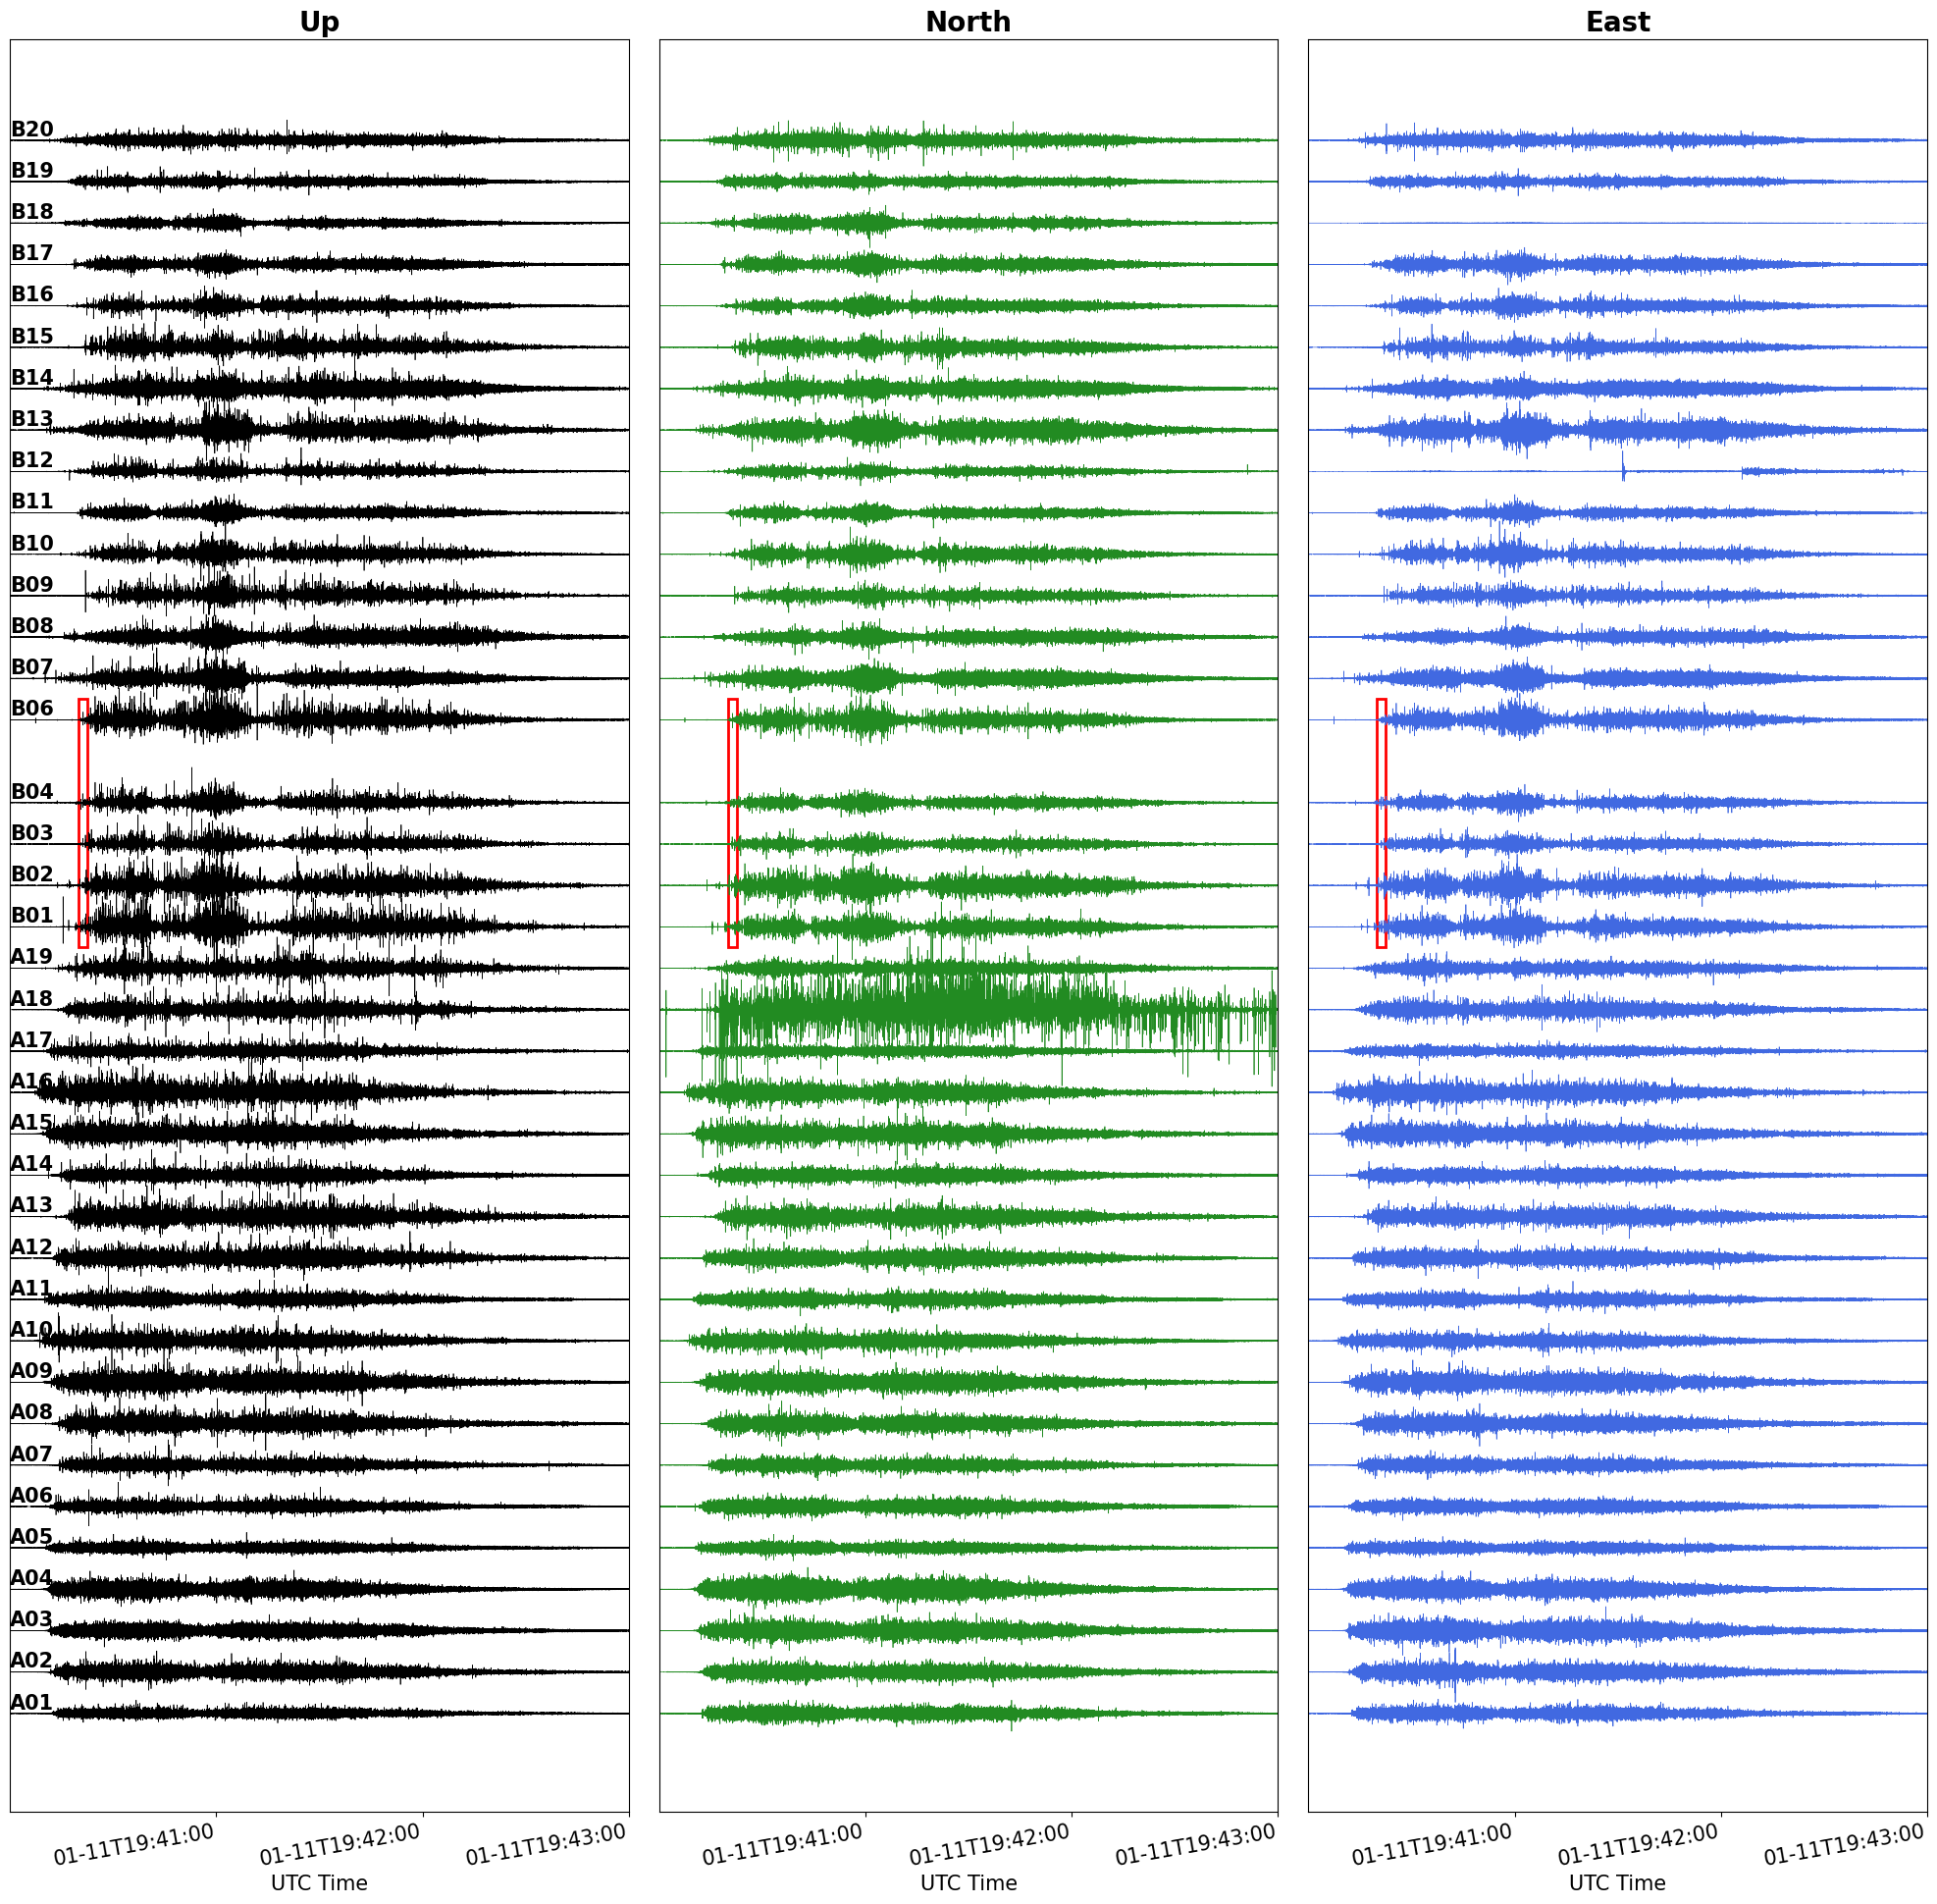

: 

In [65]:
fig, axes = subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20, 0.5*numst))

### Loop over the stations
for i, station in enumerate(stadf["name"]):

    #### Exract and plot the waveforms
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data * scale + i
        data_1 = trace_1.data * scale + i
        data_2 = trace_2.data * scale + i
    except:
        print(f"Could not plot {station}")
        continue
    
    #### Convert the time axis to Pandas Timestamps
    timeax = trace_z.times("matplotlib")
    timeax = days_to_timestamps(timeax)


    axes[0].plot(timeax, data_z, color="black", linewidth=0.5)
    axes[1].plot(timeax, data_1, color="forestgreen", linewidth=0.5)
    axes[2].plot(timeax, data_2, color="royalblue", linewidth=0.5)

    axes[0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=15, fontweight="bold")

    #### Extract and plot the raw detections
    if plot_detect:
        try:
            detdf = stalta_dict[station]
            detdf = detdf.loc[(detdf["trigger_time"] >= timeax[0]) & (detdf["trigger_time"] <= timeax[-1])]
        except:
            print(f"No detections for {station}")
            continue

        axes[0].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
        axes[1].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
        axes[2].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)

    #### Extract and plot the associated detections
    if plot_assoc:
        for event in events:
            try:
                trigger, detrigger = event.get_triggers_by_station(station)
            except:
                continue
            
            axes[0].scatter(trigger, i, color="red", zorder=11, s=size)
            axes[1].scatter(trigger, i, color="red", zorder=11, s=size)
            axes[2].scatter(trigger, i, color="red", zorder=11, s=size)

### Plot the boxes around the selected stations
if plot_boxes:
    istartstation = stadf.index[stadf["name"] == startstation][0]
    iendstation = stadf.index[stadf["name"] == endstation][0]
    endtime_box = starttime_box + Timedelta(seconds=dur_box)

    # Define the coordinates of the box corners
    x_start = starttime_box
    x_end = endtime_box
    y_start = istartstation - 0.5
    y_end = iendstation + 0.5

    # Create the rectangle patch
    rect1 = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, fill=False, edgecolor='red', linewidth=2)
    rect2 = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, fill=False, edgecolor='red', linewidth=2)
    rect3 = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, fill=False, edgecolor='red', linewidth=2)

    # Add the rectangle patch to the plot
    # Remove the lines that add the rectangles to axes[0], axes[1], and axes[2]
    # axes[0].add_patch(rect)
    # axes[1].add_patch(rect)
    # axes[2].add_patch(rect)

    # Add the rectangles to the plot after all other elements
    axes[0].add_patch(rect1)
    axes[1].add_patch(rect2)
    axes[2].add_patch(rect3)
    # axes[0].set_zorder(12)
    # axes[1].set_zorder(12)
    # axes[2].set_zorder(12)
    # axes[1].add_patch(rect)
    # axes[2].add_patch(rect)

## Set the x-axis limits
axes[0].set_xlim([timeax[0], timeax[-1]])
axes[1].set_xlim([timeax[0], timeax[-1]])
axes[2].set_xlim([timeax[0], timeax[-1]])

## Format x-axis as date time
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))

for label in axes[0].get_xticklabels():
    label.set_fontsize(15)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[1].get_xticklabels():
    label.set_fontsize(15)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[2].get_xticklabels():
    label.set_fontsize(15)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

# Set titles
axes[0].set_title("Up", fontsize=20, fontweight="bold")
axes[1].set_title("North", fontsize=20, fontweight="bold")
axes[2].set_title("East", fontsize=20, fontweight="bold")

# Set x label spacing to 60 seconds
axes[0].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[1].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[2].xaxis.set_major_locator(mdates.SecondLocator(interval=60))

# Set x labels
axes[0].set_xlabel("UTC Time", fontsize=15)
axes[1].set_xlabel("UTC Time", fontsize=15)
axes[2].set_xlabel("UTC Time", fontsize=15)


# Turn off the y-axis labels and ticks
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.tight_layout()
fig.patch.set_alpha(0.0)

## Save the figure
filename = f"sample_waveforms.png"

outpath = join(ROOTDIR, timewin, filename)
fig.savefig(outpath, dpi=300)
print(f"Saved to {outpath}")